**Самостоятельная работа №3 Эквализация**

In [219]:
# Install modulation library
!pip install -q ModulationPy tdqm google.colab

ERROR: Could not find a version that satisfies the requirement google.colab (from versions: none)
ERROR: No matching distribution found for google.colab


⚠️ Note: В этой домашней работе вам следует работать с каналом "link_chan_2", который использовался в предыдущей домашней работе.

In [3]:
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
from ModulationPy import PSKModem, QAMModem
from tqdm.notebook import tqdm, trange
from numpy import sqrt
plt.rcParams.update({'font.size': 15})

USE_GOOGLE_DRIVE = False
FOLDER_PATH = '/home/lexotr/my_gits/9_semester_programming/mimo/first_hw/Channels/'

# Which channel file you'd like to load
CHAN_NAME = 'link_chan_2.mat'.format('2')                                  #  <<< Set your value here

if USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount('/gdrive')
    CHAN_NAME = 'link_chan_{}.mat'.format('2')

os.chdir(FOLDER_PATH)

Инициализируем канальный тензор, выведем информацию о канале.

In [221]:
H = scipy.io.loadmat(CHAN_NAME)['Link_Channel'][:,:,:256,:]

N_ue_ants, N_bs_ants, N_subcarriers, N_tti = H.shape

# Some info about signal
print('Number of user antennas: ', N_ue_ants )
print('Number of base station antennas: ', N_bs_ants)
print('Number of subcarriers: ', N_subcarriers)
print('Number of time moments: ', N_tti)

Number of user antennas:  4
Number of base station antennas:  64
Number of subcarriers:  256
Number of time moments:  100


В одном из предыдущих домашних задании, подразумевалось, что одни и те же частотно-временные ресурсы были выделены как для пилотов SRS <span style="color:gray"> (Sounding Reference Signal) </span>, так и для передачи данных. В реальных же системах передачи информации для аллокации занимаемых пилот-сигналами и передаваемыми данными ресурсов, используется, к примеру, разделение по времени.

Рассмотрим простой пример, моделирующий такую ситуацию. Определимся, что мы будем отправлять пилоты SRS каждый 4-й TTI <span style="color:gray">(Time Transmission Interval)</span>, в таком случае оставшиеся незанятые пилот-сигналами TTI окажутся зарезервированы под передачу данных.

In [222]:
# Number of all TTIs in our channel
N_ofdm_symb = H.shape[-1]

# Pilot spacing
spacing_pilot = 4

# Grid with tti indices where we will send pilot symbols
pilot_positions = np.arange(start = 0,
                            stop = N_ofdm_symb,
                            step = spacing_pilot)

# Plot grid
print('Pilot TTIs:', pilot_positions)

Pilot TTIs: [ 0  4  8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92
 96]


In [223]:
# All other TTIs we will use for data transmission
data_positions = np.setdiff1d(np.arange(N_ofdm_symb), pilot_positions)
print('Data TTIs:', data_positions)

Data TTIs: [ 1  2  3  5  6  7  9 10 11 13 14 15 17 18 19 21 22 23 25 26 27 29 30 31
 33 34 35 37 38 39 41 42 43 45 46 47 49 50 51 53 54 55 57 58 59 61 62 63
 65 66 67 69 70 71 73 74 75 77 78 79 81 82 83 85 86 87 89 90 91 93 94 95
 97 98 99]


Визуализируем временнóе распределение ресурсов нашей системы.

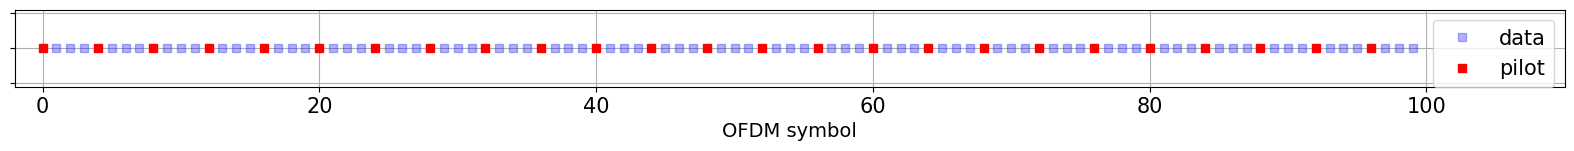

In [224]:
#Let us visualize our resources
def plot_subc(data_subc, pilot_subc):
    '''
    Plots pilot (red) and data (blue) TTI positions
    '''
    plt.figure(figsize = (20,1))
    plt.plot(data_subc, np.zeros_like(data_subc), 's',color = 'blue', label='data', alpha = 0.3, )
    plt.plot(pilot_subc, np.zeros_like(pilot_subc), 's',color = 'red', label='pilot')
    plt.xlabel('OFDM symbol', fontsize = 14)
    fr = plt.gca()
    fr.axes.yaxis.set_ticklabels([])
    plt.grid()
    plt.legend()
    plt.xlim([-2, 110])
    plt.show()

plot_subc(data_positions, pilot_positions)

В одной из предыдущих работ мы просто загружали из файла с раширением .mat сгенерированные с помощью MATLAB 5G-Toolbox последовательности Задова-Чу, представляющие собой пилоты SRS.

Определим функции, необходимые для генерации пилотов SRS. Ниже представлена реализация генератора последовательности Задова-Чу — <span style="color: #FFFFC5">ZadoffChu_gen()</span>, а также функция построения взаимной корреляции — <span style="color: #FFFFC5">correlate_time_domain()</span> — необходимая для  проверки корреляционных свойств последовательности.

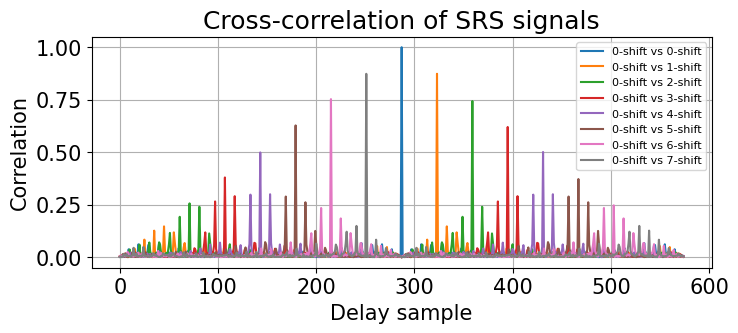

In [4]:
def ZadoffChu_gen(n_US, M_sc, ID_Ue):
    '''ZADOFFCHU_GEN Generates a Zadoff-Chu sequence used for cell search and synchronization in LTE networks.

    Inputs:
       n_US  - The number of unique sequences.
       M_sc  - The number of subcarriers.
       ID_Ue - The unique identifier for the user equipment (UE).

    Output:
       out   - The generated Zadoff-Chu sequence.
    '''

    # Configuration for Zadoff-Chu sequence generation
    N_ap = 1                                                    # Number of antenna ports

    # Length of Zadoff-Chu sequence, chosen as the max prime less than M_sc
    N_zc = max([p for p in range(2, M_sc) if all(p % n != 0 for n in range(2, p))])
    n = np.arange(N_zc)                                         # Base sequence index

    # Generate the base Zadoff-Chu sequence
    q = 10                                                      # Base root index (should be relatively prime to N_zc)
    x_q = np.exp(-2j * np.pi * q * n * (n + 1) / (2 * N_zc))
    k = np.arange(M_sc)                                         # Subcarrier indices
    r = x_q[np.mod(k, N_zc)]                                    # The sequence repeated for all subcarriers

    # Calculate the cyclic shift for the sequence
    n_rs = ID_Ue                                                # UE-specific sequence number
    p = np.arange(N_ap)                                         # Antenna port indices
    N_rs = np.mod(n_rs + n_US * p / N_ap, n_US)                 # Cyclic shift calculation
    alpha = 2 * np.pi * N_rs / n_US                             # Cyclic shift phase
    n = np.arange(len(r))                                       # Index for the final sequence

    # Initialize the output sequence matrix
    out = np.zeros((M_sc, N_ap), dtype = complex)

    # Apply the cyclic shift to generate the Zadoff-Chu sequence for each antenna port
    for index_antenna in range(len(alpha)):
        out[:, index_antenna] = np.exp(1j * alpha[index_antenna] * n) * r

    return out


def correlate_time_domain(x1, x2, normalize = True):
    '''
    Calculates crosscorreltion between two signals in the time domain.
    INPUTS:
        - x1: (np.ndarray) first signal array
        - x2: (np.ndarray) second signal array
        - normalize: (bool). If 'True' then normalize result to have max amplitude equal to 1.
          if 'False' then normalization is not applied
    OUTPUTS:
        - Absolute value of crosscorrelataion between X1 and X2, where X1 and X2
          are inverse Fourier transfrom of x1 and x2 respectively.
    '''
    X1 = np.fft.ifft(x1.flatten())
    X2 = np.fft.ifft(x2.flatten())
    corr = np.correlate(X1, X2, 'full')
    abs_corr = np.abs(corr)

    if normalize:
        abs_corr /= np.max(abs_corr)
    return abs_corr

# Plot Cross-correlation of SRS signals
plt.figure(figsize = (8,3))
for i in range(8):
    c = correlate_time_domain(ZadoffChu_gen(8, 288, 0) ,ZadoffChu_gen(8, 288, i), normalize = False)
    plt.plot(c, label = '0-shift vs {0}-shift'.format(i) )

plt.ylabel('Correlation')
plt.xlabel('Delay sample')
plt.title('Cross-correlation of SRS signals')
plt.grid()
plt.legend(fontsize = 8)
plt.show()

Нам пригодятся следующие, уже реализованные в предыдущих домашних заданиях, функции.

In [90]:
def normalize(H):
    '''
    Normalizes the channel along UE antennas and subcarriers to have unit power on each receive antenna.
    '''
    # Shape of H
    N_ue, N_bs, N_f, N_tti = H.shape

    # Calculate norms along 0,2 axis (N_ue, N_f)
    norma = np.linalg.norm(H, ord = 'fro', axis = (0,2), keepdims = True)

    # return normalized channel
    H_normed = H / norma * sqrt(N_ue)
    return H_normed


def receiver_signal(H, X, SNR_dB):
    '''
    Model signal at the receiver side. Returns received signal with noise is SNR_dB is int.
    If SNR_dB is None - returns ideal signal
    INPUTS:
        - H (np.ndarray): channel tensor with shape of [N_ue_ants x N_bs_ants x N_subcarrier]
        - X (np.ndarray): transmitted signal matrix with shape of [N_bs_ants x N_subcarrier]
        - SNR_dB (int or None): Signal to Noise ratio in decibels.

    '''
    N_ue, N_bs, N_f = H.shape

    y = np.zeros((N_ue, N_f), dtype = np.complex128)

    for f in range(N_f):
        y[:, f] = H[:,:,f] @ X[:,f]

    N = get_noise(np.mean(H, 1) * sqrt(N_bs), SNR_dB)
    return y + N


def bit_error_rate(received_bits, true_bits):
    '''Calculates bit error rate (BER) between two-bit sequences'''

    return np.mean(np.abs(received_bits - true_bits), axis = 1)[0]

def get_noise_from_full(H_mat, axis_to_sum_over, SNR_dB):
    '''Returns complex AWGN tensor for a signal with the same shape
       satisfying SNR ratio
        Inputs:
            - signal: (np.ndarray) some signal array
            - SNR: (int) SNR value in decibels, which adjusts noise power.
                    if SNR is None, return 0 (no noise at all)
       '''
    if SNR_dB is None:
        return 0
    # complex-valued AWGN with 0 mean and unit variance with same size as @signal
    noise = np.sqrt(1/2) * (np.random.randn(*H_mat.shape) + 1j*np.random.randn(*H_mat.shape))

    # Calculate mean @signal power
    P_signal = np.mean(np.abs(H_mat)**2, axis=axis_to_sum_over, keepdims=True)
    
    shape_for_tile = [1 for i in range(len(H_mat.shape))]
    for ax in axis_to_sum_over:
        shape_for_tile[ax] = H_mat.shape[ax]
    shape_for_tile = tuple(shape_for_tile)

    P_signal = np.tile(P_signal, shape_for_tile)

    # Normalize Noise to satisfy SNR
    noise_normed = noise * np.sqrt(10**(-SNR_dB/10) * P_signal)
    return noise_normed


def get_noise(signal, SNR_dB):
    '''Returns complex AWGN tensor for a signal with the same shape
       satisfying SNR ratio
        Inputs:
            - signal: (np.ndarray) some signal array
            - SNR: (int) SNR value in decibels, which adjusts noise power.
                    if SNR is None, return 0 (no noise at all)
       '''
    if SNR_dB is None:
        return 0
    # complex-valued AWGN with 0 mean and unit variance with same size as @signal
    noise = np.sqrt(1/2) * (np.random.randn(*signal.shape) + 1j*np.random.randn(*signal.shape))

    # Calculate mean @signal power
    P_signal = np.mean(np.abs(signal)**2)

    # Normalize Noise to satisfy SNR
    noise_normed = noise * sqrt(10**(-SNR_dB/10) * P_signal)
    return noise_normed

Зададимся конфигурацией нашей модели системы связи как мы уже не раз делали ранее.

Рассмотрим чуть более детально конфигурацию пользователей — мобильных терминалов <span style="color:gray">(UE - User Equipment)</span>.

⚠️ Обратим внимание на следующее:
1. С количеством антенн на пользователе мы определились в предыдущей работе — 1.
2. Количество целевых пользователей <span style="color:gray">(target UEs)</span> — 2. Целевыми мы называем те мобильные терминалы, на которых производим измерения метрик качества системы передачи информации.
3. Количество интерферирующих пользователей <span style="color:gray">(interfering UEs)</span> — 1.
4. Всего пользователей должно быть не более 4-х, поскольку в канальном тензоре больше и нет.

Также, аллоцируем для пользователей временные ресурсы и зададимся параметрами модуляции.

In [227]:
# System configuration

H = normalize(H)
N_ue_ants, N_bs_ants, N_subcarriers, N_ofdm_symb = H.shape

# UE configuration
# -------------------------------------------------------------------
N_ues = 2                   # Number of UEs for data transmission
N_interf = 1                # Number of interfering UEs
N_rx = N_ues + N_interf     # Number of all amount of UEs
assert N_rx <= 4 , 'Channel file contain only 4 UE antennas'


# Resource configuration
# -------------------------------------------------------------------
spacing_pilot = 4                       # spacing between pilots
# pilot TTIs grid
pilot_positions = np.arange(start = 0,
                            stop = N_ofdm_symb,
                            step = spacing_pilot)
# data TTIs grid
data_positions = np.setdiff1d(np.arange(N_ofdm_symb), pilot_positions)
# number of TTIs, when data was transmitted
N_data_ofdm_symb = len(data_positions)


# Modulation configuration
# -------------------------------------------------------------------
N_constellation_points = 16
N_bits_per_conts_point = int(np.log2(N_constellation_points))
modem = QAMModem(M = N_constellation_points,
                 bin_input = True,
                 gray_map = True,
                 soft_decision = False,
                 bin_output = True)
constellation_norm = (2/3 * (N_constellation_points - 1))**0.5
N_layers = 1  # No precoding. Need this variable for working with implemented functions in prev HW

В предыдущей лабораторной работе мы ввели описание пользователей в виде словаря, состоящего из данных (информационных битов), а также передаваемых в канале связи модулированных символов OFDM <span style="color:gray">(Orthogonal Frequency Division Multiplexing)</span> и пилот-сигналов.

Такое представление оказывается особенно удобным при увеличении количества целевых пользователей.

In [228]:
ues = []  # List with our UEs

# Create specified number of UEs
for ue_idx in range(N_ues):
    # And add created UE to list
    ues.append(
        dict(bits = np.zeros((N_data_ofdm_symb, N_layers, N_subcarriers, N_bits_per_conts_point)),    # allocate memory for UE bits
                symbs = np.zeros((N_data_ofdm_symb, N_layers, N_subcarriers), dtype = np.complex128), # allocated memory for UE modulated symbols
                pilot_symb = ZadoffChu_gen(N_ues, N_subcarriers, ue_idx)                              # Generate SRS pilot sequence
            )
    )

# print some info
print('Number of elements in list: ', len(ues))
print('Keys for each UE:', ues[0].keys())

Number of elements in list:  2
Keys for each UE: dict_keys(['bits', 'symbs', 'pilot_symb'])


Аналогичным образом создадим и интерферирующих пользователей, являющихся помехой для целевых. Для интерферирующих пользователей нам не нужно оценивать канал, а также строить графики оцененных метрик качества системы связи <span style="color:gray">(например, Bit-Error Rate - вероятность битовой ошибки)</span>, поэтому мы можем хранить только сигнал, который был ими отправлен.

При оценке метрик качества системы связи у целевых пользователей необходимо каким-то образом оценивать влияние помех от интерферирующих пользователей. Для этого можно использовать метрику Interference-over-Thermal-noise <span style="color:gray">(IoT)</span>, которая определяет отношение мощности помех $(P_i)$ к мощности шума $(P_n)$.

$$
IoT = \frac{P_{i}}{P_{n}}
$$

Зафиксируем значение IoT = 5 дБ и проверим работоспособность приемников, изменяя соотношение сигнал/шум <span style="color:gray">(SNR - Signal-Noise Ratio)</span>.


In [229]:
SNR_dB = 0  # will be varied
IoT_dB = 5 # fixed for all simulations

# calculate normalisation coeff
IoT = sqrt(10**(0.1 * (SNR_dB - IoT_dB)))

# list with interfered users
interf_ue = []
# Add one interfering user
interf_ue.append(
    dict(symbs = np.zeros((N_ofdm_symb, N_layers, N_subcarriers), dtype = np.complex128))
)

Теперь мы можем смоделировать передачу и прием сигнала для нескольких целевых пользователей в условиях наличия в канале интерферирущих пользователей.

In [230]:
# Allocate memory for target and interference received signal
Y_target = np.zeros((N_ofdm_symb, N_bs_ants, N_subcarriers), dtype = np.complex128)
Y_interf = np.zeros((N_ofdm_symb, N_bs_ants, N_subcarriers), dtype = np.complex128)
Y_target_noisy = np.zeros((N_ofdm_symb, N_bs_ants, N_subcarriers), dtype = np.complex128)

data_index = 0  # index that shows which DATA ofdm symbol will be created

# loop over each TTI
for t in range(N_ofdm_symb):
    # loop over all target users
    for ue_idx, ue in enumerate(ues):

        # Check if current TTI is related to Pilot grid
        if t in pilot_positions:
            # prepare sending SRS pilot signal of this UE
            current_symb = ue['pilot_symb'].T

        # Otherwise current TTI must be related with data transmission
        elif t in data_positions:
            # create bit sequence
            bits = np.random.binomial(n = 1, p = 0.5, size = (N_layers, N_subcarriers, N_bits_per_conts_point))
            symb = modem.modulate(bits.flatten()).reshape(N_layers, N_subcarriers) / constellation_norm

            # store created bits and modulated signal to ue dictionary
            ue['bits'][data_index] = bits
            ue['symbs'][data_index] = symb

            # prepare sending signal with data
            current_symb = symb

        # imposible case
        else:
            raise Exception("Ofdm symbol {0} doesn't exits in data_positions or pilot_positions")

        # Select channel for current UE and current TTI
        H_t = H[ue_idx, :, None, :, t]  # H_t has shape of [64x1x256]. "None" is used to add additional dimention

        # Modeling receiving signal from all target users simultaniously
        Y_target[t] += receiver_signal(H_t, current_symb, None)         # Ideal case without noise
        Y_target_noisy[t] += receiver_signal(H_t, current_symb, SNR_dB) # Case with noise

    # if during this step we store data, we need to use another index for further storing
    if t in data_positions: data_index += 1

    # Similar procedure with interfered user
    #-------------------------------------------------------------------------------------------------
    # select last ue antenna channel as interfered
    H_t_interf = H[-1, :, None, :, t]

    # generate some interfered bits
    bits = np.random.binomial(n = 1, p = 0.5, size = (N_layers, N_subcarriers, N_bits_per_conts_point))

    # interfered user
    current_symb = modem.modulate(bits.flatten()).reshape(N_layers, N_subcarriers) / constellation_norm

    # Normalized interfered signal. We use additional norm with number of target users, because we received sum of signals from UEs
    Y_interf[t] += receiver_signal(H_t_interf / IoT * sqrt(N_ues) , current_symb, None) # Don't use Noise here.


    # Finally
    #--------------------------------------------------------------------------------------------------
    # This is your final received signal.
    # depending on the scenario you may use target signal with/without noise and interfered signal.
    Y_rx_noise_interf = Y_target_noisy + Y_interf

**Оценка канала**

Итак, мы получили сигнал и теперь необходимо оценить канал.
Как вы помните, этот шаг выполняется с использованием ресурсов, в которых были переданы известные пилотные символы, поэтому нам нужно извлечь необходимые индексы этих ресурсов.

Затем нам нужно использовать оценку по методу наименьших квадратов, чтобы оценить наш канал с шумом и помехами от соседних пользователей:
$$
\mathop{\mathrm{\hat{h}_{UL}(k,t)}}_{N \times 1} = \mathop{\mathrm{y_p(k,t)}}_{N\times 1} \mathop{\mathrm{s_p^*(k,t)}}_{1 \times 1}
$$

Помните, что для каждого целевого пользователя мы используем свой собственный пилот-сигнал $s_p$.

In [231]:
# Extraction all pilots from each UE into one matrix
pilots = np.zeros((N_subcarriers, N_ues), dtype = np.complex128)

for ue_idx, ue in enumerate(ues):
    pilots[:,ue_idx] = ue['pilot_symb'].flatten()

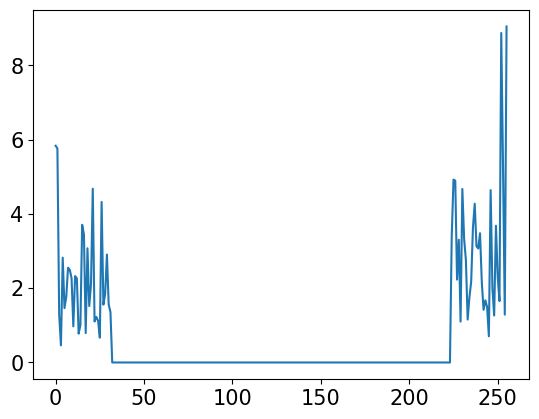

In [232]:
# Least Squared Estimation
H_est = np.zeros((N_ues, N_bs_ants, N_subcarriers, N_tti), dtype = np.complex64)
for pilot_pos in pilot_positions:
    for ue_idx in range(N_ues):
        h_ls = Y_rx_noise_interf[pilot_pos] * (pilots[:,ue_idx].conj().T)
        h_ls_pure = Y_target[pilot_pos] * (pilots[:,ue_idx].conj().T)
        if (pilot_pos == 0) and (ue_idx == 0):
            imp_resp = np.fft.fft(h_ls, axis=-1)
            imp_resp[:, 32:-32] = 0
            plt.figure()
            plt.plot(np.abs(imp_resp[0]))
            plt.show()


        H_est[ue_idx,:,:,pilot_pos] = h_ls

Давайте представим идеальный и зашумленный каналы. Из предыдущего домашнего задания вы наверняка помните, что канал является разреженным в области лучей и задержек. Поэтому, чтобы показать разницу и понять стратегию подавления шума и помех, мы можем построить всего один срез канального тензора.

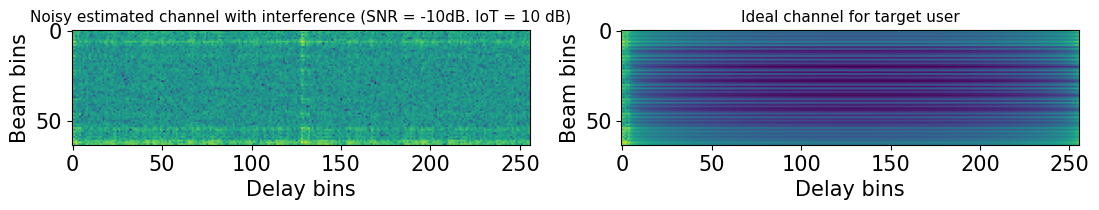

In [233]:
H_interf_noise_slice = H_est[0,:,:,0]
H_ideal_slice = H[0,:,:,0]

def to_beam_delay(H):
    '''
    Transfroms signal from Antenna-Frequency domain into Beam-Delay domain
    H is channel matrix with shape of [N_ants x N_subcarriers]
    '''
    Z = np.fft.fft(H, axis = 0, norm = 'ortho')     # Beam domain transform
    Z = np.fft.ifft(Z, axis = -1, norm = 'ortho')   # Delay domain transform
    return Z

beam_delay_noisy_amplitudes = np.abs(to_beam_delay(H_interf_noise_slice))
beam_delay_ideal_amplitudes = np.abs(to_beam_delay(H_ideal_slice))


plt.figure(figsize = (13,7))
plt.subplot(1,2,1)
plt.imshow(10*np.log10(beam_delay_noisy_amplitudes))
plt.title('Noisy estimated channel with interference (SNR = -10dB. IoT = 10 dB)', fontsize = 11)
plt.xlabel('Delay bins'); plt.ylabel('Beam bins')

plt.subplot(1,2,2)
plt.title('Ideal channel for target user', fontsize = 11)
plt.imshow(10*np.log10(beam_delay_ideal_amplitudes))
plt.xlabel('Delay bins'); plt.ylabel('Beam bins')
plt.show()

Как видите, очень важно восстановить целевой сигнал без шума и помех во время процедуры оценки канала. Для этих целей мы можем использовать оконный фильтр в области задержек, как в предыдущем домашнем задании! Далее у нас будет реализация функции оценки канала, которую вам предстоит завершить реализацией оконного фильтра!

А пока, предположим, что у нас есть идеальная оценка канала для пилотных ресурсов. Мы имеем оценку канала только в те TTI, которые отведены на пилот-сигналы, а нам нужно иметь оценку канала всех тех TTI, в которых мы передаем наши данные. В простейшем случае, мы можем использовать линейную интерполяцию, чтобы восстановить сигнал и для других моментов времени. Давайте визуализируем оцененный канал до интерполяции и после нее. Для этого мы можем построить график распределения мощности по TTI и поднесущим следующим образом:

In [234]:
# Attention! Here we use IDEAL channel estimation to present problem with interpolation.
# in your simulations you should use real estimation (if the task does not assumes using ideal CE)
H_est = np.zeros((N_ues, N_bs_ants, N_subcarriers, N_tti), dtype = np.complex64)
H_est[...,pilot_positions] = H[:N_ues,...,pilot_positions]

# Interpolate the channel estimates for non-pilot positions
H_est_full = np.zeros_like(H_est)
for ant_bs_index in range(N_bs_ants):
    for ue_index in range(N_ues):
        for sc_index in range(N_subcarriers):
            # Extract the channel estimate for the current subcarrier
            H_slice = H_est[ue_index, ant_bs_index, sc_index, pilot_positions]

            # Perform linear interpolation across symbols
            F = scipy.interpolate.interp1d(pilot_positions, H_slice, kind='linear', fill_value='extrapolate')

            # Apply the interpolation to estimate the channel across all symbols
            H_est_full[ue_index, ant_bs_index, sc_index, :] = F(np.arange(N_ofdm_symb))

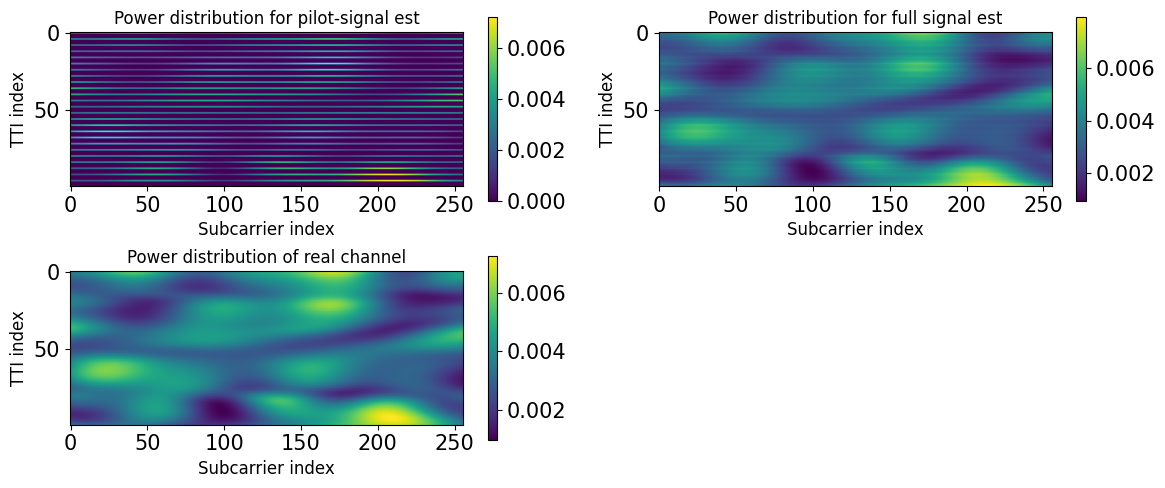

In [235]:
# This is a signal which we have after channel estimation
plt.figure(figsize = (12,5))
plt.subplot(2,2,1)
plt.imshow(np.mean(np.abs(H_est[0])**2, axis = 0).T)
plt.xlabel('Subcarrier index', fontsize = 12); plt.ylabel('TTI index', fontsize = 12)
plt.title('Power distribution for pilot-signal est', fontsize = 12)
plt.colorbar()

# This is a signal which obtained using interpolation of the previous image
plt.subplot(2,2,2)
plt.imshow(np.mean(np.abs(H_est_full[0])**2, axis = 0).T)
plt.colorbar()
plt.xlabel('Subcarrier index', fontsize = 12); plt.ylabel('TTI index', fontsize = 12)
plt.title('Power distribution for full signal est', fontsize = 12)

# This is ideal signal
plt.subplot(2,2,3)
plt.imshow(np.mean(np.abs(H[0])**2, axis = 0).T)
plt.colorbar()
plt.xlabel('Subcarrier index', fontsize = 12); plt.ylabel('TTI index', fontsize = 12)
plt.title('Power distribution of real channel', fontsize = 12)
plt.tight_layout()


Теперь мы можем объединить все эти шаги в одну функцию оценки канала:


⭕️ <font color = 'red'>Задание: закончить функцию применения оконного фильтра в области задержек для функции оценки канала

In [123]:
from numpy.fft import fft, ifft, fftshift, ifftshift

def channel_estimation(Y_target, ues, pilot_positions, window_size=None):
    '''
    Performs channel estimation using received and transmitted pilots.
    Also performs channel interpolation for full resource grid.

    INPUTS:
        - Y_target - received pilot symbols with shape of  [N_ofdm_symb x N_bs_ants xN_subcarriers]
        - ues - (list) list with target UE dictionaries
        - pilot_positions - array with TTI indices where pilots was transmitted
    OUTPUT:
        - H_est_full - denoised and interpolated channel estimation for all resources.
    '''

    N_ofdm_symb, N_bs_ants, N_subcarriers = Y_target.shape
    N_ues = len(ues)

    Y_transposed = np.transpose(Y_target, (1, 2, 0)) # now [N_bs, N_subcar, N_ofdm_symb]
    Y_transposed = np.tile(Y_transposed, (N_ues, 1, 1, 1)) # now [N_ues, N_bs, N_subcar, N_ofdm_symb]

    # pilot extraction
    pilots_symb_amount = pilot_positions.size
    pilots = np.zeros((N_ues, N_bs_ants, N_subcarriers, pilots_symb_amount), dtype = np.complex128)

    for ue_idx, ue in enumerate(ues):
        pilot_symb = ue['pilot_symb'].flatten()
        pilot_symb = np.expand_dims(pilot_symb, (0, 2))
        pilot_symb = np.tile(pilot_symb, (N_bs_ants, 1, pilots_symb_amount))
        pilots[ue_idx, ...] = pilot_symb

    # LS Estimation
    H_est_on_pilots = Y_transposed[..., pilot_positions] * pilots.conj()
    h_ls = np.fft.ifft(H_est_on_pilots, axis=-1, norm='ortho')
    h_ls[..., window_size: -window_size, :] = 0
    H_est_on_pilots = np.fft.ifft(h_ls, axis=-1, norm='ortho')
    
    H_est = np.zeros((N_ues, N_bs_ants, N_subcarriers, N_ofdm_symb), dtype = np.complex128)
    H_est[..., pilot_positions] = H_est_on_pilots

    H_est_full = np.zeros_like(H_est)
    for ant_bs_index in range(N_bs_ants):
        for ue_index in range(N_ues):
            for sc_index in range(N_subcarriers):
                # Extract the channel estimate for the current subcarrier
                H_slice = H_est[ue_index, ant_bs_index, sc_index, pilot_positions]

                # Perform linear interpolation across symbols
                F = scipy.interpolate.interp1d(pilot_positions, H_slice, kind='linear', fill_value='extrapolate')

                # Apply the interpolation to estimate the channel across all symbols
                H_est_full[ue_index, ant_bs_index, sc_index, :] = F(np.arange(N_ofdm_symb))

    return H_est_full

Теперь мы хотим получить данные, которые были отправлены. Нам не нужен канал или принятый сигнал в позициях пилотов, поэтому мы извлекаем канал и принятый сигнал для позиций данных:

In [237]:
# Here you have to choose: Real CE or Ideal
print(len(ues))

# Ideal channel estimation
H_est = H

# Real channel estimation
H_est = channel_estimation(Y_rx_noise_interf, ues, pilot_positions) #

# extract estimated channels for data positions
H_data = H_est[0:N_ues, :, :, data_positions]

# extract received signal for data positions
Y_data = Y_rx_noise_interf[data_positions]

2


Наконец, нам нужно провести эквализацию. Это основная часть домашнего задания. Ниже вам нужно реализовать несколько важных типов приемников

# **Zero Forcing**

Предположим, что у нас есть аддитивная смесь сигнала с шумом:
$$
\mathrm{y = Hx +n}
$$

Мы оценили канал $\mathrm{H}$ и получили сигнал $\mathrm{y}$, нам нужно получить сигнал $\mathrm{x}$, который был отправлен. Это можно переформулировать в виде следующей оптимизационной задачи:
$$
x_{LS} = \operatorname{argmin} \|\ \mathrm{Hx - y} \|^2
$$
Эта задача имеет единственное решение при условии, что столбцы канальной матрицы линейно независимы, и его можно получить из так называемого нормального уравнения (после умножения каждой стороны уравнения на $\mathrm{H^H}$):
$$
\mathrm{H^HHx = H^Hy}
$$
Решением в данном случае будет:
$$
\mathrm{x_{ZF} = W_{ZF}y = (H^HH)^{-1}H^Hy}
$$
где $\mathrm{W_{ZF} = (H^HH)^{-1}H^H}$ — вектор коэффициентов эквалайзера.

С математической точки зрения полученное решение является определением для обобщенной инверсии матрицы, называемой псевдоинверсией Мура-Пенроуза:
$$
\mathrm{H^† = (H^HH)^{-1}H^H}
$$
Этот оператор известен из предыдущего домашнего задания, где мы использовали функцию ``pinv`` в качестве эквалайзера. Это означает, что мы как раз-таки использовали Zero Forcing.


From a mathematical point of view obtained solution is a definition for generalized matrix inversion called Moore-Penrose pseudoinverse:
$$
\mathrm{H^† = (H^HH)^{-1}H^H}
$$
This operator is known from the previous HW, where we used ```pinv``` function for the equalizer. So it means that we used the Zero Forcing approach.

⭕️ <font color='red'>Задание: реализовать приемник Zero Forcing, используя приведенное выше решение (без функции ``pinv``). Вы можете проверить свое решение с помощью ``pinv``, чтобы понять, правильно ли вы его реализовали.

In [7]:
def my_pinv(mat, sigma=1e-6):
    mat_H = np.moveaxis(mat.conj(), -1, -2)
    identity_len = mat.shape[-1]
    repeated_identity = np.tile(np.eye(identity_len), (mat_H.shape[0], mat_H.shape[1], 1, 1))
    # print(f"rep ident shape {repeated_identity.shape}, called pinv with {sigma}")
    mat_H_mat_inv = np.linalg.inv(np.matmul(mat_H, mat) + sigma * sigma * repeated_identity)
    return np.matmul(mat_H_mat_inv, mat_H)

In [8]:
def zero_forcing(mat):
    return my_pinv(mat)

# **Minimal Mean Squared Error (MMSE)**

В решении для приемника Zero Forcing вы можете заметить, что мы не использовали никакой предварительной информации о шуме. В MMSE мы пытаемся устранить этот существенный недостаток с помощью регуляризации матрицы перед операцией инверсии. Причем, коэффициент регуляризации в данном случае оказывается зависимым от дисперсии шума.

Решение для эквалайзера MMSE можно записать следующим образом:
$$
\mathrm{W_{MMSE} = (H^HH+\sigma^2I)^{-1}H^H}
$$
где $\mathrm{I}$ — единичная матрица, а $\sigma$ — дисперсия шума.

Таким образом, видно, что для такого приемника нам необходимо оценить дисперсию шума. Это можно сделать непосредственно, получив шум и найдя его дисперсию, или сделать это справедливо, оценив дисперсию шума в области задержек лучей (найдя лучи и задержки, в которых нет целевого или мешающего сигнала)

⭕️ <font color = 'red'>Задание: реализовать MMSE-эквалайзер, используя полученное решение.

In [9]:
def mmse(mat, sigma):
    return my_pinv(mat, sigma)

# **Interference Rejection Combiner (IRC)**
В предыдущих двух приемниках мы не использовали никакой предварительной информации о помехах, создаваемых интерферирующими пользователями. Рассмотрим такой случай:
$$
\mathrm{y = Hx + n + u}
$$
где $u$ — сигнал помехи ("интерференции"), описываемый уровнем IoT.

Эквалайзер IRC был создан для случаев, когда помехи вызывают значительное ухудшение производительности системы связи. Такой подход использует предварительную информацию о сигнале помехи и тесно связан с фильтром Винера:

$$
\mathrm{W_{IRC} = R_{xy}R_{yy}^{-1} = H^H(HH^H + R_{uu} + I)^{-1}}
$$

После упрощений:
$$
\mathrm{W_{IRC} = (H^HR_{uu}^{-1}H + I)^{-1}H^HR_{uu}^{-1}}
$$
где $\mathrm{R_{uu}}$ — ковариационная матрица сигнала помехи.

В вашем коде вы можете вычислить ее, используя сигнал помехи, следующим образом:

Предположим, что вы получили сигнал от мешающего пользователя:
$$
\mathrm{Y_{u}} \in \mathbb{C}^{N \times K \times T}
$$
где $N - $количество антенн на базовой станции. $K-$ количество поднесущих, $T-$ количество TTI.

Нам необходимо получить ковариационную матрицу формы $N \times N$, поэтому мы должны записать $\mathrm{Y_{u}} \in \mathbb{C}^{N \times KT}$.
Тогда же $\mathrm{R_{uu}}$ можно будет получить следующим образом:
$$
\mathrm{R_{uu}} = \frac{1}{KT} Y_u Y_u^H + \sigma I
$$
где $\sigma$ — дисперсия шума.

⭕️ <font color = 'red'> Ваша задача - реализовать IRC-приемник, используя полученные выражения.

In [10]:
def irc(mat, sigma, Y_u):
    # maybe problems with batching,  be carefull
    Y_u_reshaped = np.reshape(Y_u, (Y_u.shape[0], -1))
    N, KT = Y_u_reshaped.shape

    R_uu = np.matmul(Y_u_reshaped, Y_u_reshaped.conj().T) / KT + np.eye(N) * sigma
    R_inv = np.linalg.inv(R_uu)
    R_inv_repeated = np.tile(R_inv, (mat.shape[0], mat.shape[1], 1, 1))
    # print(f"In irc: Y_u {Y_u.shape}, Y_u_reshape {Y_u_reshaped.shape} ruu shape {R_uu.shape}, repeated: {R_inv_repeated.shape}")

    mat_H = np.moveaxis(mat.conj(), -1, -2)
    repeated_identity = np.tile(np.eye(mat.shape[-1]), (mat_H.shape[0], mat_H.shape[1], 1, 1))
    W_irc = (np.linalg.inv(((mat_H @ R_inv_repeated) @ mat) + repeated_identity) @ mat_H) @ R_inv_repeated

    return W_irc

Приведем реализацию блока эквалайзера в нашей модели системы связи.

In [11]:
def Equalizer(Y_signal, H_data, receiver_type='ZF', noise_var = None, Y_u = None):
    # Y in [N_tti x N_bs x N_f]
    # H in [N_ue x N_bs x N_f x N_tti]

    # print(f"Got in equalizer {Y_signal.shape}, {H_data.shape}")
    H_transposed = np.transpose(H_data, (3, 2, 1, 0))
    Y_transposed = np.transpose(Y_signal, (0, 2, 1))
    Y_transposed = np.expand_dims(Y_transposed, 3)
    # print(f"Now {Y_transposed.shape}, {H_transposed.shape}")

    if receiver_type == 'ZF' or receiver_type == 'default':
        W_mat = zero_forcing(H_transposed) # <<<<<<<<< you may need to modify it


    if receiver_type == 'MMSE':
        W_mat = mmse(H_transposed, np.sqrt(noise_var))         # <<<<<<<<< you may need to modify it


    if receiver_type == 'IRC':
        Y_u_transposed = np.transpose(Y_u, (1, 2, 0))
        W_mat = irc(H_transposed, noise_var, Y_u_transposed)
    # print(f"Before apply {W_mat.shape}, {Y_transposed.shape}")

    est_symbols = np.matmul(W_mat, Y_transposed)
    return np.squeeze(est_symbols, 3)

После эквализации мы можем демодулировать символы и получить принятые биты, рассчитать BER.

In [243]:
symbs_est = np.rollaxis(Equalizer(Y_data, H_data, receiver_type = 'ZF'), 2, 1)
print(symbs_est.shape)
for ue_idx, ue in enumerate(ues):
    true_bits = ue['bits']
    est_bits = modem.demodulate(symbs_est[:,ue_idx,:].flatten() * constellation_norm)

    print(bit_error_rate(true_bits.reshape(1,-1), est_bits.reshape(1,-1)))

(75, 2, 256)
0.4714453125
0.4684765625


In [244]:
del H

In [103]:
def prepare_Y(H, spacing_pilot, SNR_dB, N_ues, N_interf = 1, IoT_dB = 5):
    N_rx = N_ues + N_interf     # Number of all amount of UEs
    assert N_rx <= 4 , 'Channel file contain only 4 UE antennas'

    H = normalize(H)
    N_ue_ants, N_bs_ants, N_subcarriers, N_ofdm_symb = H.shape

    # Resource configuration
    # -------------------------------------------------------------------
    # pilot TTIs grid
    pilot_positions = np.arange(start = 0,
                                stop = N_ofdm_symb,
                                step = spacing_pilot)
    # data TTIs grid
    data_positions = np.setdiff1d(np.arange(N_ofdm_symb), pilot_positions)
    # number of TTIs, when data was transmitted
    N_data_ofdm_symb = len(data_positions)


    # Modulation configuration
    # -------------------------------------------------------------------
    N_constellation_points = 16
    N_bits_per_conts_point = int(np.log2(N_constellation_points))
    modem = QAMModem(M = N_constellation_points,
                    bin_input = True,
                    gray_map = True,
                    soft_decision = False,
                    bin_output = True)
    constellation_norm = (2/3 * (N_constellation_points - 1))**0.5
    N_layers = 1  # No precoding. Need this variable for working with implemented functions in prev HW

    ues = []  # List with our UEs

    # Create specified number of UEs
    for ue_idx in range(N_ues):
        # And add created UE to list
        ues.append(
            dict(bits = np.zeros((N_data_ofdm_symb, N_layers, N_subcarriers, N_bits_per_conts_point)),    # allocate memory for UE bits
                    symbs = np.zeros((N_data_ofdm_symb, N_layers, N_subcarriers), dtype = np.complex128), # allocated memory for UE modulated symbols
                    pilot_symb = ZadoffChu_gen(N_ues, N_subcarriers, ue_idx)                              # Generate SRS pilot sequence
                )
        )

    # calculate normalisation coeff
    IoT = sqrt(10**(0.1 * (SNR_dB - IoT_dB)))

    data_positions_size = data_positions.size
    
    all_data_bits = np.random.binomial(n = 1, p = 0.5, size = (N_ues, data_positions_size, N_subcarriers, N_bits_per_conts_point))
    all_data_symbs = modem.modulate(all_data_bits.flatten()).reshape(N_ues, data_positions_size, N_subcarriers) / constellation_norm

    for ue_idx in range(N_ues):
        ues[ue_idx]['bits'] = all_data_bits[ue_idx]
        ues[ue_idx]['symbs'] = all_data_symbs[ue_idx]

    all_syms = np.zeros((N_ues, N_ofdm_symb, N_subcarriers), dtype = np.complex128)
    all_syms[:, data_positions, :] = all_data_symbs
    
    pilot_positions_size = pilot_positions.size
    pilot_mat = np.zeros((N_ues, pilot_positions_size, N_subcarriers), dtype = np.complex128)
    for ue_idx in range(N_ues):
        pilot_symb = np.squeeze(ues[ue_idx]['pilot_symb'], 1)
        pilot_symb_repeated = np.tile(pilot_symb, (pilot_positions_size, 1))
        pilot_mat[ue_idx] = pilot_symb_repeated
    
    all_syms[:, pilot_positions, :] = pilot_mat

    all_syms_transposed = np.expand_dims(np.transpose(all_syms, (2, 1, 0)), 3)
    H_transposed = np.transpose(H, (2, 3, 1, 0)) # now [subcar, tti, N_bs, N_ue]
    Y_target = H_transposed[..., :N_ues] @ all_syms_transposed

    Y_target = np.squeeze(Y_target, 3)

    H_for_noise = np.mean(H_transposed[..., :N_ues], 3) * np.sqrt(N_ues)
    noise_full = get_noise_from_full(H_for_noise, axis_to_sum_over=(0, 2), SNR_dB=SNR_dB)

    Y_target_noisy = Y_target + noise_full

    Y_target = np.transpose(Y_target, (1, 2, 0)) # now [tti, bs, freq]
    Y_target_noisy = np.transpose(Y_target_noisy, (1, 2, 0)) # now [tti, bs, freq]

    # generate some interfered bits
    bits_interf = np.random.binomial(n = 1, p = 0.5, size = (N_subcarriers, N_ofdm_symb, N_bits_per_conts_point))

    # interfered user
    symbs_interf = modem.modulate(bits_interf.flatten()).reshape(N_subcarriers, N_ofdm_symb) / constellation_norm
    symbs_interf = np.expand_dims(np.expand_dims(symbs_interf, 2), 3)
    H_interf = H_transposed[..., -2:-1]
    Y_interf = (H_interf @ symbs_interf) / IoT * sqrt(N_ues)
    Y_interf = np.squeeze(Y_interf, 3)
    Y_interf = np.transpose(Y_interf, (1, 2, 0))

    Y_rx_noise_interf = Y_target_noisy + Y_interf
    return ues, Y_target, Y_target_noisy, Y_interf, Y_rx_noise_interf
    

In [13]:
def test_new_prepare():
    H = scipy.io.loadmat(CHAN_NAME)['Link_Channel'][:,:,:256,:]
    H = normalize(H)
    N_ue_ants, N_bs_ants, N_subcarriers, N_ofdm_symb = H.shape
    res = prepare_Y(H, 4, -3, 2)

In [100]:
test_new_prepare()

(256, 100, 64)
(256, 100, 64)
(100, 64, 256)


In [114]:
def equalizer_exp(H, N_ues, spacing_pilot, SNR_dB, equalizer_type='ZF', IoT_dB=5, Y_to_use=2, use_H_est=True):

    N_ue_ants, N_bs_ants, N_subcarriers, N_ofdm_symb = H.shape
    ue, Y_target, Y_target_noisy, Y_interf, Y_rx_noise_interf = prepare_Y(H, spacing_pilot, SNR_dB, N_ues, IoT_dB=IoT_dB)
    # print(ue[0]['pilot_symb'] - ue[1]['pilot_symb'])
    match Y_to_use:
        case 0:
            Y_to_work_with = Y_target
        case 1:
            Y_to_work_with = Y_target_noisy
        case 2:
            Y_to_work_with = Y_rx_noise_interf

    pilot_positions = np.arange(start = 0,
                                stop = N_ofdm_symb,
                                step = spacing_pilot)
    data_positions = np.setdiff1d(np.arange(N_ofdm_symb), pilot_positions)

    N_ue, N_bs, N_subcarriers, N_tti = H.shape

    H_est = H[0:N_ues]
    if use_H_est:
        H_est = channel_estimation(Y_to_work_with, ue, pilot_positions, 32)
    # print(H_est[0, 0, :, pilot_positions[0]])
    # print(H[0, 0, :, pilot_positions[0]])
    # print(np.divide(H_est[0, 0, :, pilot_positions[0]], H[0, 0, :, pilot_positions[0]]))
    # print(H_to_eval_against.shape)

    # extract estimated channels for data positions
    H_data = H[0:N_ues, :, :, data_positions]

    # extract received signal for data positions
    Y_data = Y_to_work_with[data_positions]
    
    Y_u = np.zeros_like(Y_target)
    if Y_to_use == 2:
        Y_u = Y_interf
    signal_pwr = np.sum(np.square(np.abs(Y_target))) / Y_target.size
    if Y_to_use > 0:
        noise_pwr = signal_pwr / (10 ** (SNR_dB / 10))
    else:
        noise_pwr = 1e-6 * signal_pwr
    received_data = Equalizer(Y_data, H_data, equalizer_type, noise_var=noise_pwr , Y_u=Y_u)
    received_data = np.rollaxis(received_data, 2, 1)

    # print(f"Got shape {received_data.shape}, and have {ue[0]['symbs'].shape}")
    
    N_constellation_points = 16
    modem = QAMModem(M = N_constellation_points,
                    bin_input = True,
                    gray_map = True,
                    soft_decision = False,
                    bin_output = True)
    constellation_norm = (2/3 * (N_constellation_points - 1))**0.5

    bit_error = 0
    # estimated bit sequence observed with noise
    for i in range(0, N_ues):
        est_bits  = modem.demodulate(received_data[:, i, :].flatten() * constellation_norm)
        true_bits = modem.demodulate(ue[i]['symbs'].flatten() * constellation_norm)
        bit_error += np.sum(np.abs(est_bits - true_bits))
    # # print(f"est bits shape {est_bits.shape}")
    # # print(f"bits reshaped {bits.reshape(1,-1).shape}")
    ber = bit_error / (received_data.size * np.log2(N_constellation_points))
    # print(ber)
    # print(f"res shape {res.shape}, {res}")
    # if to_plot:
    #     plt.figure(figsize=(11,3))
    #     plt.plot(np.abs(H[0,0,10]),'r', label = 'ideal')
    #     plt.plot(np.abs(H_est[0,0,10]), '.-g', label = 'interpolated')
    #     plt.legend()
    #     plt.xlabel('Time interval'); plt.ylabel('signal magnetude')
    #     plt.title('Estimated channel slice')
    #     plt.grid()
    return H_est, ber

In [82]:
def test_out():
    H = scipy.io.loadmat(CHAN_NAME)['Link_Channel'][:,:,:256,:]
    H = normalize(H)
    N_ue_ants, N_bs_ants, N_subcarriers, N_ofdm_symb = H.shape
    N_used = 2
    N_constellation_points = 16
    N_bits_per_conts_point = int(np.log2(N_constellation_points))
    modem = QAMModem(M = N_constellation_points,
                    bin_input = True,
                    gray_map = True,
                    soft_decision = False,
                    bin_output = True)
    constellation_norm = (2/3 * (N_constellation_points - 1))**0.5
    N_layers = 1  # No precoding. Need this variable for working with implemented functions in prev HW

    bits = np.random.binomial(n = 1, p = 0.5, size = (N_layers, N_subcarriers, N_bits_per_conts_point))

    symbs = np.zeros((N_used, N_subcarriers), dtype=np.complex128)
    symbs[0] = modem.modulate(bits.flatten()).reshape(N_subcarriers) / constellation_norm
    symbs[1] = modem.modulate(bits.flatten()).reshape(N_subcarriers) / constellation_norm

    H_t = H[0:N_used, :, :, 0]  # H_t has shape of [64x1x256]. "None" is used to add additional dimention
    H_t = np.transpose(H_t, (1, 0, 2))
    received = np.zeros((N_bs_ants, N_subcarriers), dtype=np.complex128)
    for i in range(N_subcarriers):
        received[:, i] = H_t[..., i] @ symbs[..., i]

    recovered = np.zeros((N_used, N_subcarriers), dtype=np.complex128)
    print(received.shape, H_t.shape, symbs.shape, recovered.shape)

    for i in range(N_subcarriers):
        recovered[:, i] = np.linalg.pinv(H_t[..., i]) @ received[..., i]

    print(recovered - symbs)

In [95]:
test_out()

(64, 256) (64, 2, 256) (2, 256) (2, 256)
[[-5.55111512e-17-5.55111512e-16j -4.44089210e-16+5.55111512e-17j
   0.00000000e+00-7.77156117e-16j -1.66533454e-16+1.66533454e-16j
  -8.88178420e-16-2.77555756e-16j -6.66133815e-16-1.66533454e-16j
  -2.77555756e-16-2.77555756e-16j  5.55111512e-17+0.00000000e+00j
   5.55111512e-16+2.77555756e-16j  0.00000000e+00+4.44089210e-16j
   2.77555756e-16-1.66533454e-16j -3.33066907e-16+5.55111512e-17j
   4.99600361e-16+2.22044605e-16j  2.22044605e-16+0.00000000e+00j
  -4.44089210e-16-6.66133815e-16j -5.55111512e-17-2.22044605e-16j
  -2.22044605e-16+6.66133815e-16j  2.77555756e-16-1.66533454e-16j
  -4.44089210e-16-2.22044605e-16j  4.44089210e-16-1.11022302e-16j
   1.66533454e-16+4.44089210e-16j  5.55111512e-17+4.44089210e-16j
   1.66533454e-16-1.66533454e-16j  5.55111512e-17+5.55111512e-17j
   0.00000000e+00-1.11022302e-16j -3.88578059e-16-4.44089210e-16j
   1.66533454e-16-2.22044605e-16j  1.66533454e-16-2.22044605e-16j
   3.33066907e-16-2.77555756e-16j -

In [83]:
def ber_snr_graph(H, N_ues, snr_range, pilot_spacing, eq_type, Y_to_use = 2, use_H_est=True, IoT=5):
    ber_arr = np.zeros_like(snr_range, dtype=np.float128)
    for i, snr in tqdm(enumerate(snr_range), total = snr_range.size):
        est, ber = equalizer_exp(H, N_ues, pilot_spacing, snr, eq_type, IoT, Y_to_use=Y_to_use, use_H_est=use_H_est)
        ber_arr[i] = ber

    return ber_arr

In [216]:
def task2():
    H = scipy.io.loadmat(CHAN_NAME)['Link_Channel'][:,:,:256,:]
    H = normalize(H)
    N_ues = 2
    pilot_spacing = 4

    snr_range = np.arange(-15, 10)

    eq_types = ['ZF', 'MMSE']
    colors = ['.-g', '.-b']
    for color, eq_type in zip(colors, eq_types):
        bers = ber_snr_graph(H, N_ues, snr_range, pilot_spacing, eq_type, Y_to_use=1, use_H_est=False)
        plt.plot(snr_range, bers, color, label=f"{eq_type} equalizer")
        print(bers)
    plt.legend(fontsize = 10)
    plt.yscale('log')
    plt.show()

In [217]:
def task3():
    H = scipy.io.loadmat(CHAN_NAME)['Link_Channel'][:,:,:256,:]
    H = normalize(H)
    N_ues = 2
    pilot_spacing = 4

    snr_range = np.arange(-15, 10)

    eq_types = ['ZF', 'MMSE']
    colors = ['.-g', '.-b']
    for color, eq_type in zip(colors, eq_types):
        bers = ber_snr_graph(H, N_ues, snr_range, pilot_spacing, eq_type, Y_to_use=1, use_H_est=True)
        plt.plot(snr_range, bers, color, label=f"{eq_type} equalizer")
        print(bers)
    plt.legend(fontsize = 10)
    plt.yscale('log')
    plt.show()

In [222]:
def task4():
    H = scipy.io.loadmat(CHAN_NAME)['Link_Channel'][:,:,:256,:]
    H = normalize(H)
    N_ues = 2
    pilot_spacing = 4

    snr_range = np.arange(-15, 10)

    eq_types = ['ZF', 'MMSE', 'IRC']
    colors = ['.-g', '.-b', '.-r']
    for color, eq_type in zip(colors, eq_types):
        bers = ber_snr_graph(H, N_ues, snr_range, pilot_spacing, eq_type, Y_to_use=2, use_H_est=True, IoT=10)
        plt.plot(snr_range, bers, color, label=f"{eq_type} equalizer")
        print(bers)
    plt.legend(fontsize = 10)
    plt.yscale('log')
    plt.show()

In [223]:
def task5():
    H = scipy.io.loadmat(CHAN_NAME)['Link_Channel'][:,:,:256,:]
    H = normalize(H)
    N_ues = 2
    pilot_spacing = 4

    snr_range = np.arange(-15, 10)

    eq_types = ['ZF', 'MMSE', 'IRC']
    colors = ['.-g', '.-b', '.-r']
    for color, eq_type in zip(colors, eq_types):
        bers = ber_snr_graph(H, N_ues, snr_range, pilot_spacing, eq_type, Y_to_use=2, use_H_est=True, IoT=0)
        plt.plot(snr_range, bers, color, label=f"{eq_type} equalizer")
        print(bers)
    plt.legend(fontsize = 10)
    plt.yscale('log')
    plt.show()

In [ ]:
def main():
    H = scipy.io.loadmat(CHAN_NAME)['Link_Channel'][:,:,:256,:]
    H = normalize(H)
    N_ues = 2
    pilot_spacing = 4

    snr_range = np.arange(-10, 11)

    eq_types = ['ZF', 'MMSE', 'IRC']
    colors = ['.-g', '.-b', '.-r']
    # eq_types = ['ZF', 'MMSE']
    # colors = ['.-g', '.-b']
    # eq_types = ['ZF']
    # colors = ['.-g']
    for color, eq_type in zip(colors, eq_types):
        bers = ber_snr_graph(H, N_ues, snr_range, pilot_spacing, eq_type, Y_to_use=2)
        plt.plot(snr_range, bers, color, label=f"{eq_type} equalizer")
        print(bers)
    plt.legend(fontsize = 10)
    plt.yscale('log')
    plt.show()

    # print(est.shape)
    # plt.figure()
    # plt.plot(np.abs(est[0, 0, 0]), '.-g')
    # plt.plot(np.abs(H[0, 0, 0]), '.-b')

  0%|          | 0/2 [00:00<?, ?it/s]

[0. 0.]


  0%|          | 0/2 [00:00<?, ?it/s]

[0. 0.]


  0%|          | 0/2 [00:00<?, ?it/s]

[0. 0.]


/tmp/ipykernel_379010/1800867035.py:20: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


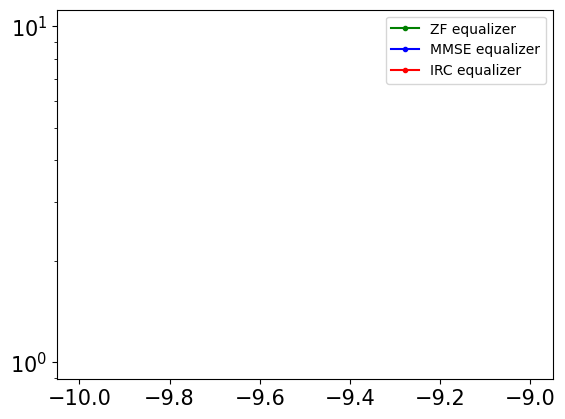

In [124]:
main()

<font color = 'red'> Задания:


⭕️ <font color = 'red'> 1. Реализовать код для моделирования систем с различными уровнями SNR.

⭕️ <font color = 'red'> 2. Постройте кривые зависимости BER от SNR для эквалайзеров ZF и MMSE, используя идеальную оценку канала и принимаемый сигнал без помех. Объясните результат.

⭕️ <font color = 'red'> 3. Постройте кривые BER vs SNR для эквалайзеров ZF и MMSE, используя неидеальную оценку канала без помех. Объясните, как качество оценки канала влияет на производительность, сравнивая с графиками в пункте 2.

⭕️ <font color = 'red'> 4. Постройте кривые зависимости BER от SNR для эквалайзеров ZF и MMSE, IRC, используя неидеальную оценку канала и принимая сигнал с помехами (IoT = 10 дБ). Объясните полученные результаты

⭕️ <font color = 'red'> 5. Построить кривые зависимости BER от SNR для ZF и MMSE, IRC эквалайзера с использованием неидеальной оценки канала и принимаемого сигнала с помехами (IoT = 0 дБ). Объясните полученные результаты
